# Handle Imbalanced Dataset

## Exploratory Data Analysis

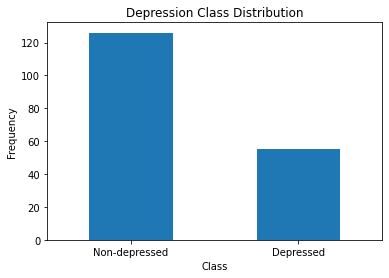

The ratio of negative to positive cases is 2.29.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../../data/clean_compiled_transcripts.csv")

count_classes = pd.value_counts(df.PHQ_Binary)
count_classes.plot(kind = 'bar', rot=0)
labels = ["Non-depressed", "Depressed"]

plt.title("Depression Class Distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

print(f"The ratio of negative to positive cases is {round(count_classes[0] / count_classes[1], 2)}.")

Clearly, the dataset is highly imbalanced and is likely to result in poor performance. We should strive for 50:50 during training.

## Split the dataset
There are 2 reasons for splitting the dataset first:
1. We need to convert transcripts to word embeddings. The tokenizer should only be trained on the train set, instead of the entire corpus.
2. Due to an imbalanced dataset, we will be applying undersampling techniques later. In case we decide to use oversampling techniques (which we are not), splitting first prevents the possibility of the exact same observations being present in both the train and test sets, which could lead to overfitting and poor generalization to the test data.

In [2]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42 # lucky number

X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(df.Transcript, df.PHQ_Binary, test_size=0.2, random_state=RANDOM_STATE)

## Convert transcripts to padded sequences

In [3]:
# Tokenization and padding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_raw)
vocab_size = len(tokenizer.word_index) + 1

Using TensorFlow backend.


In [4]:
maxlen = 1000

def prepare(X):
    X_seq = tokenizer.texts_to_sequences(X)
    X_mat = sequence.pad_sequences(X_seq, maxlen=maxlen)
    
    return X_mat

In [5]:
X_train_mat = prepare(X_train_raw)
X_test = prepare(X_test_raw)

X_train_mat.shape, X_test.shape

((144, 1000), (37, 1000))

## Undersampling
We will be using undersampling techniques instead of oversampling because we cannot be not sure of the new data points generated.

In [6]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.6/site-packages (0.7.0)


In [7]:
from imblearn.under_sampling import RandomUnderSampler

# the ratio of minority class to majority class will be 1 after resampling
us = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

X_train_full, y_train_full = us.fit_sample(X_train_mat, y_train_raw)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=RANDOM_STATE)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((70, 1000), (18, 1000), (70,), (18,))

Now we have `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test` ready to be used for model training, validation and testing. If we are using cross-validation techniques, we can use `X_train_full`, `y_train_full`.

# More preprocessing

## Data Normalization
Most classifiers work best if data is normalized.

In [8]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
x_scaler.fit(X_train)

X_train_full_norm = x_scaler.transform(X_train_full)
X_train_norm = x_scaler.transform(X_train)
X_val_norm = x_scaler.transform(X_val)
X_test_norm = x_scaler.transform(X_test)

## Evaluation metrics
Some considerations in evaluation metrics when deciding our model.
1. In our use case, it is more important to have high sensitivity as want to correctly identify as many depression cases out of all actual depression cases for early intervention. Predicting a non-depressed person as depressed is comparatively less severe, meaning we prioritize TPR (sensitivity) over FPR.
2. We will also try using `f1_score` (default: returns the score for positive class in the `binary` case) to prioritize the prediction for the positive class. Because we have evenly distributed the train set, using `macro` or `weighted` puts equal weight on both classes and removes the priority that we want.

Note:
* Sensitivity = true positive rate = recall = TP / (TP + FN)
* Specificity = true negative rate = TN / (TN + FP)
* Fall out = false positive rate = FP / (FP + TN)
* Miss rate = false negative rate = FN / (FN + TP)

Metrics can be found on this [website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score

def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  
  # print out recall and precision
  print(classification_report(y_test, y_pred))
  
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')

## Run model

In [10]:
def run_model(input_model, X_train, X_test, y_train, y_test):
    model = input_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Model Implementation

## Decision Tree

AUC is:  0.5227272727272727
              precision    recall  f1-score   support

           0       0.72      0.50      0.59        26
           1       0.32      0.55      0.40        11

    accuracy                           0.51        37
   macro avg       0.52      0.52      0.50        37
weighted avg       0.60      0.51      0.53        37

Confusion Matrix: 
 [[13 13]
 [ 5  6]]


DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)

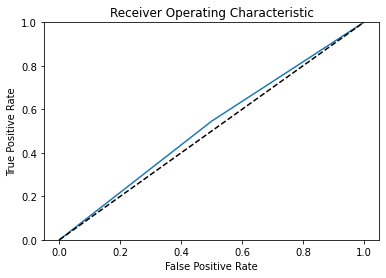

In [11]:
from sklearn.tree import DecisionTreeClassifier

def find_best_tree_model(upper_depth, upper_leaf):
    best_model = None
    best_f1 = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            
            f1 = f1_score(y_val, y_pred)
            
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
    
    return best_model

best_tree_model = find_best_tree_model(80, 30)

run_model(best_tree_model, X_train, X_test, y_train, y_test)

## SVM with grid search

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.5s


AUC is:  0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.30      1.00      0.46        11

    accuracy                           0.30        37
   macro avg       0.15      0.50      0.23        37
weighted avg       0.09      0.30      0.14        37

Confusion Matrix: 
 [[ 0 26]
 [ 0 11]]
Best SVM parameters: {'C': 1, 'degree': 3, 'kernel': 'poly'}


[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    3.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


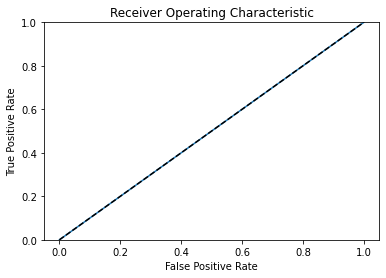

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

best_svm_model = run_model(svm_model_cv, X_train_full_norm, X_test_norm, y_train_full, y_test)
print(f"Best SVM parameters: {best_svm_model.best_params_}")

Based on the output, the model appears to maximize the recall rates with a small degree of precision in order to obtain the most optimal `f1 score`. The model probably uses a soft decision boundary that is overfitted to the training data, resulting in any unseen data point being disproportionately classified as depressed cases (with label = 1). For this reason, SVM is not a good option. Also, it does not provide probability outcomes as a measure of its confidence level, which would be valuable for professionals to evaluate in a medical situation.